# Model Training and Selection

**Goal:** Train multiple regression models, evaluate performance, tune hyperparameters, and save the best model.


In [67]:
# ===========================
# Imports
# ===========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os


## Load Processed Data

In [45]:
# Load train/test data from /data/processed
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

y_train_sq = y_train.squeeze()
y_test_sq = y_test.squeeze()


## Baseline Models
- Linear Regression
- Ridge Regression
- Lasso Regression

In [54]:
def train_baseline_models(X_train, y_train):
    """
    Train Linear, Ridge, and Lasso regressors.
    Returns dictionary of trained models.
    """
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso()
    }

    for name, model in models.items():
        model.fit(X_train,y_train)
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        print(f"{name}: Mean R2 = {scores.mean():.4f}")
    
    return models


In [55]:
baseline_models = train_baseline_models(X_train, y_train_sq)

LinearRegression: Mean R2 = 0.9885
Ridge: Mean R2 = 0.9885
Lasso: Mean R2 = 0.9885


In [57]:
baseline_models['LinearRegression'].coef_
baseline_models['LinearRegression'].intercept_

3982.719523570665

## Tree-Based Models
- Random Forest
- XGBoost

In [58]:
def train_tree_models(X_train, y_train):
    """
    Train Random Forest and XGBoost regressors.
    """
    models = {
        'XGBoost': XGBRegressor(random_state=42, verbosity=0)
    }

    for name, model in models.items():
        model.fit(X_train,y_train)
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        print(f"{name}: Mean R2 = {scores.mean():.4f}")
    
    return models


In [59]:
tree_models = train_tree_models(X_train, y_train_sq)

XGBoost: Mean R2 = 0.9876


## Hyperparameter Tuning (Example: Random Forest)

In [ ]:
def tune_hyperparameters(model, X_train, y_train):
    """
    Example GridSearch for Random Forest.
    """
    param_grid ={
    'n_esitmators':[20,40,50],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,4,5],
    }
    random = RandomizedSearchCV(model, param_grid, cv=3, scoring='r2', n_iter=10)
    random.fit(X_train, y_train)
    print('Best params:', random.best_params_)
    print('Best score:', random.best_score_)
    return random.best_estimator_


In [60]:
best_rf_model = tune_hyperparameters(tree_models['XGBoost'], X_train, y_train_sq)

C:\Users\framanad\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'n_estimators': 100, 'max_depth': None}


In [61]:
best_rf_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

## Evaluation on Test Set

In [62]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate trained model on test data.
    """
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")
    return mae, rmse, r2


In [64]:
evaluate_model(baseline_models['LinearRegression'], X_test, y_test)

MAE: 259.6582
RMSE: 90643.6796
R2: 0.9881


(259.65815152707137, 90643.67964759456, 0.9880713622627424)

### Feature Importance


In [70]:

def plot_feature_importance_linear(model, feature_names):
    """Plot feature importance for Linear Regression using coefficients."""
    feature_importance = model.coef_
    coef_df = pd.DataFrame(feature_importance, index=feature_names, columns=['Coefficients'])
    coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

    plt.figure(figsize=(8, 4))
    plt.barh(coef_df.index, coef_df['Coefficients'])
    plt.xlabel('Coefficient Values')
    plt.title('Feature Importance in Linear Regression')
    plt.tight_layout()
    plt.show()

def plot_feature_importance_xgb(model, feature_names):
    """Plot feature importance for XGBoost using feature_importances_."""
    feature_importance = model.feature_importances_
    coef_df = pd.DataFrame(feature_importance, index=feature_names, columns=['Importance'])
    coef_df = coef_df.sort_values(by='Importance', ascending=True)

    plt.figure(figsize=(8, 4))
    plt.barh(coef_df.index, coef_df['Importance'])
    plt.xlabel('Importance Values')
    plt.title('Feature Importance in XGBoost')
    plt.tight_layout()
    plt.show()


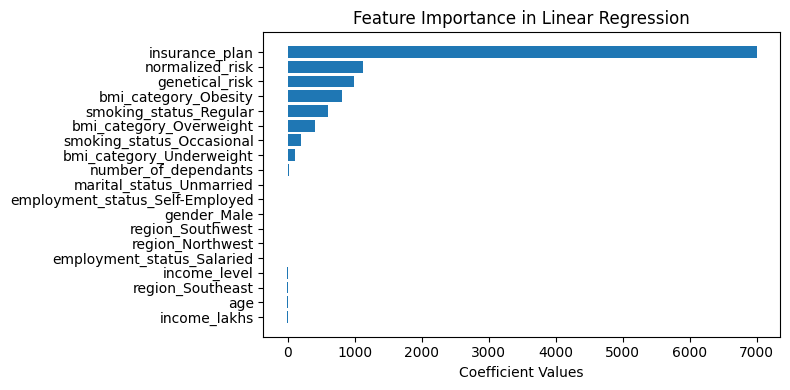

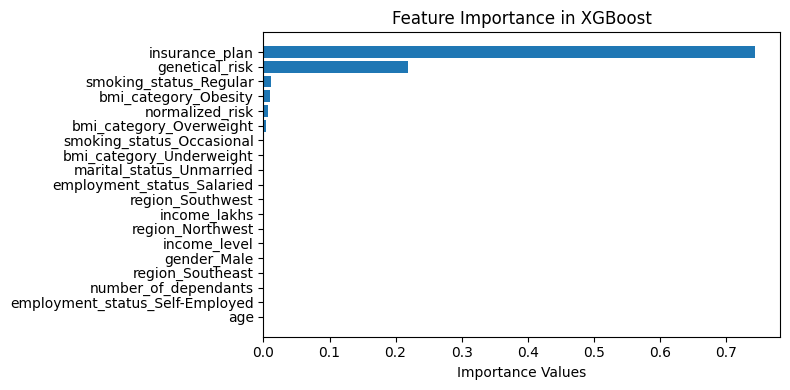

In [72]:

plot_feature_importance_linear(baseline_models['LinearRegression'], X_test.columns)
plot_feature_importance_xgb(best_rf_model,  X_test.columns)


## Save Best Model

In [36]:
def save_model(model, output_path='../models/best_model.pkl'):
    """
    Save trained model using joblib.
    """
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    joblib.dump(model, output_path)
    print(f"✅ Model saved at {output_path}")


In [65]:


save_model(baseline_models['LinearRegression'])

✅ Model saved at ../models/best_model.pkl


## Summary
✅ Trained baseline models  
✅ Trained tree-based models  
✅ Hyperparameter tuning  
✅ Evaluation on test data  
✅ Best model saved  
